In [26]:
import random
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [43]:
# ------------- * FUNCTIONS * -------------

def get_content(file_path):
    data = pd.read_csv(file_path)
    labels = data['Health_Issue']
    features = data.drop('Health_Issue', axis=1)
    
    # ..transforming categorical values into numeric values..
    for column in features.columns:
        if(features[column].dtype == 'object'):
            features[column] = features[column].astype('category').cat.codes
            
    testing_samples = int(20 * len(data) / 100)
    
    testing_labels = labels.iloc[:testing_samples].to_numpy()
    testing_features = features.iloc[:testing_samples].to_numpy()
    
    training_labels = labels.iloc[testing_samples:].to_numpy()
    training_features = features.iloc[testing_samples:].to_numpy()
    
    scaler = StandardScaler()
    # ..the scaler is used to normalize input data so
    # it all fit into the same scale, because, it there's numbers
    # that are too distinct, the bigger ones have more weight 
    # in the models result, and it leads to bigger errors..
            
    return testing_labels, scaler.fit_transform(testing_features), training_labels, scaler.fit_transform(training_features)

def xavier_initialization(input_dim, output_dim):
    return np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / (input_dim + output_dim))
    # ..the weights being too big or too small can
    # impact directly the learning process, in this case,
    # xavier initialization is applied because is a good
    # match for the tanh activation function..
    
def lecun_initialization(input_dim, output_dim):
    stddev = np.sqrt(1.0 / input_dim)
    return np.random.normal(0.0, stddev, (output_dim, input_dim))
    # lecun initialization is applied because is a good
    # match for the relu activation function..

def test_model(weights):
    sample = random.randrange(0, testing_samples)
    
    input_biased = np.hstack((bias, testing_features[sample]))
        
    output1 = np.tanh(weights['weights1'].dot(input_biased))
    output1_biased = np.hstack((bias, output1))
    
    output2 = np.tanh(weights['weights2'].dot(output1_biased))
    output2_biased = np.hstack((bias, output2))
    
    output3 = np.tanh(weights['weights3'].dot(output2_biased))
    output3_biased = np.hstack((bias, output3))
    
    result = np.tanh(weights['weights4'].dot(output3_biased))
    
    return result, testing_labels[sample]

def early_stopping(weights):
    testing_times = 100
    testing_errors = np.zeros(testing_times)
    
    for k in range(testing_times):
        test_result, test_label = test_model(weights)
        error = test_label - test_result
        testing_errors[k] = (error * error)/2
        
    mean_error = testing_errors.mean()
        
    return True if mean_error < 0.05 else False
    # ..using samples the model didn't use for 
    # training to check it's performance..
    
def reached_convergence(errors_mean):
    if(np.count_nonzero(errors_mean) < 500):
        return False
    
    diff = np.diff(errors_mean[-250:])
    result = np.all(diff)
    
    return True if result >= 0 else False
    # ..calculates if the lastest 25 values in 
    # errors array are almost the same, indicating 
    # they are not getting any lower...

def save_weights(filename, weights_dict):    
    with open(filename, 'wb') as f:
        pickle.dump(weights_dict, f)
        
def load_weights(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"No weights file found at {filename}")
    
    with open(filename, 'rb') as f:
        weights = pickle.load(f)

    return weights

def save_props(filename, props):
    np.save(filename, props)

def load_props(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"No weights file found at {filename}")
    
    props = np.load(filename, allow_pickle=True)  
    return props

def relu(x):
    return np.maximum(0, x)
# ..if the value is positive, 
# returns the value..

def relu_derivative(x):
    return np.where(x > 0, 1, 0)
# ..if the value is positive,
# returns 1, otherwise, returns 0..

In [35]:
# ------------- * CONSTANTS * -------------

dataset = 'synthetic_covid_impact_on_work.csv'
testing_labels, testing_features, training_labels, training_features = get_content(dataset)

training_samples = len(training_features)
testing_samples = len(testing_features)

epocs = 100000 
# ..each epoc represents the time when all
# the data has been ran throught, if it's too big
# it's probably going to lead your model to overfitting..

learning_rate = 0.01
# ..keep it low, this value has 
# a lot of power in progressing the weights..

patterns = training_features.shape[1]
# ..how many features there is 
# to train from..

bias = 1
# ..changes the function's angle..

input_neurons = patterns
hidden_neurons1 = 82
hidden_neurons2 = 128
hidden_neurons3 = 64
output_neurons = 1

In [36]:

# ------------- * VARIABLES * -------------

# ..the weights matrix need to have 1 column more
# because the bias is going to be inserted later on..

tm_weights1 = xavier_initialization(input_neurons + 1, hidden_neurons1)
tm_weights2 = xavier_initialization(hidden_neurons1 + 1, hidden_neurons2)
tm_weights3 = xavier_initialization(hidden_neurons2 + 1, hidden_neurons3)
tm_weights4 = xavier_initialization(hidden_neurons3 + 1, output_neurons)
# ..weights for the model using hyperbolic 
# tangent as activation function..

rm_weights1 = lecun_initialization(input_neurons + 1, hidden_neurons1)
rm_weights2 = lecun_initialization(hidden_neurons1 + 1, hidden_neurons2)
rm_weights3 = lecun_initialization(hidden_neurons2 + 1, hidden_neurons3)
rm_weights4 = lecun_initialization(hidden_neurons3 + 1, output_neurons)
# ..weights for the model using relu
# as activation function..

errors = np.zeros(training_samples)
errors_mean = np.zeros(epocs)

In [ ]:
# ------------- * HYPERBOLIC TANGENT MODEL * -------------

# ..for each sample in each epoc..
for i in range(epocs):
    for j in range(training_samples):
        
        # ..inserting the bias into the inputs, 
        # multiplying it with it's respective weight 
        # matrix and applying the activation function..
        input_biased = np.hstack((bias, training_features[j]))
        
        output1 = np.tanh(tm_weights1.dot(input_biased))
        output1_biased = np.hstack((bias, output1))
        
        output2 = np.tanh(tm_weights2.dot(output1_biased))
        output2_biased = np.hstack((bias, output2))
        
        output3 = np.tanh(tm_weights3.dot(output2_biased))
        output3_biased = np.hstack((bias, output3))
        
        result = np.tanh(tm_weights4.dot(output3_biased))
        
        # ..get the error and make it quadractic so it's more noticeble,
        # bigger errors tend to outstand more..
        error = training_labels[j] - result
        errors[j] = (error ** 2)/2
        
        # ..calculates the delta for the layer
        # and finds the value to adjust the layer behind 
        # by multiplying it's matrix with the delta..  
        delta4 = error * (1 - result ** 2)  
        
        vdelta3 = tm_weights4.transpose().dot(delta4) 
        delta3 = vdelta3 * (1 - output3_biased ** 2)
        
        vdelta2 = tm_weights3.transpose().dot(delta3[1:]) # ..skipping the bias..
        delta2 = vdelta2 * (1 - output2_biased ** 2)
        
        vdelta1 = tm_weights2.transpose().dot(delta2[1:]) # ..skipping the bias..
        delta1 = vdelta1 * (1 - output1_biased ** 2)
        
        # ..adjust the weight's matrixes 
        # with it's respective delta found..
        tm_weights1 += learning_rate * np.outer(delta1[1:], input_biased)
        tm_weights2 += learning_rate * np.outer(delta2[1:], output1_biased)
        tm_weights3 += learning_rate * np.outer(delta3[1:], output2_biased)
        tm_weights4 += learning_rate * np.outer(delta4, output3_biased)
        
    # ..saving the weights to use it
    # later on..
    weights = {
        'weights1': tm_weights1,
        'weights2': tm_weights2,
        'weights3': tm_weights3,
        'weights4': tm_weights4
    }
    
    save_weights("weights_tanh.pkl", weights)
    save_props("errors_mean_tanh", weights)
            
    # ..stopping when reaching such accuracy in 
    # testing to avoid overfitting..
    if(early_stopping(weights)):
        print("early stopping: model hit 80% or more of accuracy in testing.")
        break
    
    # ..stopping when the model has reached it's 
    # convergence state so it won't start losing
    # performance..
    if(reached_convergence(errors_mean)):
        print("the model stopped learning because it hit it's convergency point.")
        break
    
    errors_mean[i] = errors.mean()
    print(f"mean error of epoch ({i}): {errors_mean[i]}")

In [ ]:
# ------------- * RELU MODEL * -------------
for i in range(epocs):
    for j in range(training_samples):
        
        # ..using relu function as activation this time..
        input_biased = np.hstack((bias, training_features[j]))
        
        output1 = relu(rm_weights1.dot(input_biased))
        output1_biased = np.hstack((bias, output1))
        
        output2 = relu(rm_weights2.dot(output1_biased))
        output2_biased = np.hstack((bias, output2))
        
        output3 = relu(rm_weights3.dot(output2_biased))
        output3_biased = np.hstack((bias, output3))
        
        result = relu(rm_weights4.dot(output3_biased))
        
        error = training_labels[j] - result
        errors[j] = (error ** 2) / 2
        
        # ..and using the it's derivative to find deltas..
        delta4 = error * relu_derivative(result)
        
        vdelta3 = rm_weights4.transpose().dot(delta4)
        delta3 = vdelta3 * relu_derivative(output3_biased)
        
        vdelta2 = rm_weights3.transpose().dot(delta3[1:])
        delta2 = vdelta2 * relu_derivative(output2_biased)
        
        vdelta1 = rm_weights2.transpose().dot(delta2[1:]) 
        delta1 = vdelta1 * relu_derivative(output1_biased)
        
        rm_weights1 += learning_rate * np.outer(delta1[1:], input_biased)
        rm_weights2 += learning_rate * np.outer(delta2[1:], output1_biased)
        rm_weights3 += learning_rate * np.outer(delta3[1:], output2_biased)
        rm_weights4 += learning_rate * np.outer(delta4, output3_biased)
        
    weights = {
        'weights1': rm_weights1,
        'weights2': rm_weights2,
        'weights3': rm_weights3,
        'weights4': rm_weights4
    }
    
    save_weights("weights_relu.pkl", weights)
    save_props("errors_mean_relu", weights)
            
    if(early_stopping(weights)):
        print("early stopping: model hit 80% or more of accuracy in testing.")
        break
    
    # if(reached_convergence()):
    #     print("the model stopped learning because it hit it's convergency point.")
    #     break
    
    errors_mean[i] = errors.mean()
    print(f"mean error of epoch ({i}): {errors_mean[i]}")
    

TypeError: unhashable type: 'dict'

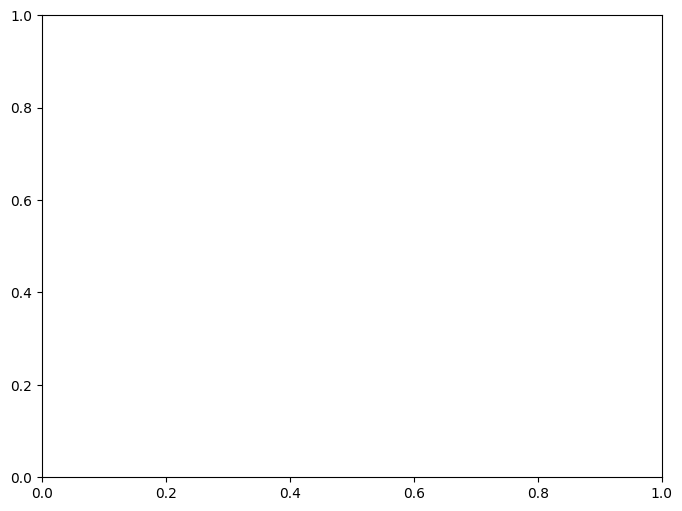

In [45]:
errors_tanh = load_props("errors_mean_tanh.npy")
errors_relu = load_props("errors_mean_relu.npy")

# Example data
epochs = np.arange(1, np.size(errors_tanh)) 
error = errors_tanh

# Create line plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, error, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()